In [1]:
# importing dependencies for file access, model, visualisations
import pandas as pd
import tensorflow as tf
import keras.backend as K
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, TFBertForSequenceClassification
from datasets import Dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from collections import Counter



# importing dependencies for testing
import chardet

In [2]:
# Defining helper functions for chunking with overlap and 
def chunk_text(text, max_length, overlap):
    """
    Chunk the text into segments that won't exceed the max_length even after tokenization.
    - text: Input string.
    - max_length: The maximum token length after tokenization.
    - overlap: Number of tokens to overlap between segments.
    """
    # Tokenize the text and get words
    words = tokenizer.tokenize(text)

    # Split the words into chunks based on the max_length and overlap
    chunks = []
    while words:
        chunk = []
        while words and len(chunk) + len(words[0]) <= max_length - overlap:
            word = words.pop(0)
            chunk.append(word)
        chunks.append(tokenizer.convert_tokens_to_string(chunk))

    return chunks

def most_frequent_label(predictions):
    """
    Determine label by counting the most frequent prediction among chunks.
    - predictions: List of predicted labels for each chunk.
    """
    # Use a Counter to count occurrences of each label and get the most common one
    return Counter(predictions).most_common(1)[0][0]


In [3]:
def load_data_from_directory(base_dir):
    """
    Load data and integer labels from the directory structure.

    Parameters:
    - base_dir: The directory containing label-based subdirectories

    Returns:
    - texts: A list of texts from the files
    - labels: A corresponding list of integer labels
    """
    texts = []
    labels = []

    # Loop through each directory in the base directory
    for label_dir in os.listdir(base_dir):
        # Ensure it's actually a directory
        if os.path.isdir(os.path.join(base_dir, label_dir)):
            # Extract label from the directory name (here we extract the prefixing number)
            label_int = int(label_dir.split('_')[0]) - 1  # subtracting 1 to make labels start from 0

            # Loop through each file in the directory
            for filename in os.listdir(os.path.join(base_dir, label_dir)):
                if filename.endswith(".txt"):
                    with open(os.path.join(base_dir, label_dir, filename), 'r', encoding='utf-8') as file:
                        texts.append(file.read())
                        labels.append(label_int)

    return texts, labels


base_dir = "/Users/jeromejaggi/Desktop/MSc Dissertation/6_Data"
texts, labels = load_data_from_directory(base_dir)
print("✅ Loaded", len(texts), "documents.")

✅ Loaded 51 documents.


In [4]:
# Ensure all file encodings are UTF-8

def detect_file_encodings(base_dir):
    encodings = {}

    for label_dir in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, label_dir)):
            for filename in os.listdir(os.path.join(base_dir, label_dir)):
                if filename.endswith(".txt"):
                    file_path = os.path.join(base_dir, label_dir, filename)

                    # Detect encoding of the file
                    with open(file_path, 'rb') as file:
                        result = chardet.detect(file.read())
                        file_encoding = result['encoding']
                        encodings[file_path] = file_encoding

    return encodings

base_dir = "/Users/jeromejaggi/Desktop/MSc Dissertation/6_Data"
file_encodings = detect_file_encodings(base_dir)

# Print out the files and their detected encodings if not ascii or utf-8
counter = 0
for file, encoding in file_encodings.items():
    if encoding == "ascii" or encoding =="utf-8":
        counter += 1
    else:
        print(f" ❌ {file}: {encoding}")
        
print(f"✅ {counter} files checked and confirmed ascii or utf-8")

✅ 51 files checked and confirmed ascii or utf-8


In [5]:
# Convert all files to UTF-8 encoding, commented out after use

def convert_to_utf8(file_path):
    with open(file_path, 'rb') as file:
        content = file.read()
        detected_encoding = chardet.detect(content)['encoding']

        # Handle potential None value
        if not detected_encoding:
            detected_encoding = 'utf-8'

    # Decode with detected encoding and then re-encode in UTF-8
    content_decoded = content.decode(detected_encoding, errors='replace')
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content_decoded)

directory_path = "/Users/jeromejaggi/Desktop/MSc Dissertation/6_Data"
for root, dirs, files in os.walk(directory_path):
    for filename in files:
        if filename.endswith(".txt"):
            file_path = os.path.join(root, filename)
            #convert_to_utf8(file_path) #no longer needed in final code


In [6]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Chunk the texts
chunked_texts = [chunk_text(text, max_length=510, overlap=50) for text in texts]

# Flatten the chunked_texts and labels for training
flat_texts = [chunk for doc in chunked_texts for chunk in doc]
flat_labels = [label for label, doc in zip(labels, chunked_texts) for chunk in doc]

# Tokenize the chunked texts
encoded_texts = tokenizer(flat_texts, truncation=True, padding=True, max_length=512, return_tensors='tf')

print("Total chunks created:", len(flat_texts))
print("Total labels available:", len(flat_labels))

if len(encoded_texts['input_ids']) != len(flat_labels):
    print("Mismatched lengths!")
    print("Length of encoded_texts:", len(encoded_texts['input_ids']))
    print("Length of labels:", len(flat_labels))
else:
    print("Lengths match!")
print(" ✅Data has been tokenized, chunked, and split into training and validation sets.")


Total chunks created: 143
Total labels available: 143
Lengths match!
 ✅Data has been tokenized, chunked, and split into training and validation sets.


2023-08-16 17:47:58.191505: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-08-16 17:47:58.191533: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-08-16 17:47:58.191538: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-08-16 17:47:58.191569: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-16 17:47:58.191582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Prepare data for k-fold cross-validation
input_ids_np = np.array(encoded_texts['input_ids'])
labels_np = np.array(flat_labels)  # for flattened labels

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

history_per_fold = []

fold = 0
for train_index, val_index in kf.split(input_ids_np):
    fold += 1
    print(f"Training for fold {fold}")

    # Split data for this fold
    train_inputs, val_inputs = input_ids_np[train_index], input_ids_np[val_index]
    train_labels, val_labels = labels_np[train_index], labels_np[val_index]

    # Initialize and compile model for each fold
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
    optimizer = Adam(learning_rate=5e-6, epsilon=1e-08)
    loss = 'sparse_categorical_crossentropy'
    metric = ['accuracy']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metric)

    # Train the model on this fold's data
    history = model.fit(train_inputs, train_labels, epochs=3, batch_size=16, validation_data=(val_inputs, val_labels))
    history_per_fold.append(history.history)

Training for fold 1


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


2023-08-16 17:48:07.014772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 10.0127 - accuracy: 0.1579

2023-08-16 17:50:40.882569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 218s 19s/step - loss: 10.0127 - accuracy: 0.1579 - val_loss: 5.1595 - val_accuracy: 0.4138
Epoch 2/3
8/8 [==============================] - 14s 2s/step - loss: 6.8643 - accuracy: 0.2895 - val_loss: 5.5029 - val_accuracy: 0.3793
Epoch 3/3
8/8 [==============================] - 12s 2s/step - loss: 5.9878 - accuracy: 0.2719 - val_loss: 6.0412 - val_accuracy: 0.3793
Training for fold 2


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


2023-08-16 17:52:11.905879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 9.6523 - accuracy: 0.1667

2023-08-16 17:55:18.761444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 251s 23s/step - loss: 9.6523 - accuracy: 0.1667 - val_loss: 8.7656 - val_accuracy: 0.3103
Epoch 2/3
8/8 [==============================] - 17s 2s/step - loss: 5.9570 - accuracy: 0.2544 - val_loss: 4.9846 - val_accuracy: 0.3103
Epoch 3/3
8/8 [==============================] - 18s 2s/step - loss: 4.2665 - accuracy: 0.2281 - val_loss: 5.4869 - val_accuracy: 0.3793
Training for fold 3


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


2023-08-16 17:57:01.075533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 10.3225 - accuracy: 0.2105

2023-08-16 18:00:20.967789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 300s 28s/step - loss: 10.3225 - accuracy: 0.2105 - val_loss: 6.8993 - val_accuracy: 0.4138
Epoch 2/3
8/8 [==============================] - 27s 3s/step - loss: 6.1382 - accuracy: 0.4298 - val_loss: 3.7908 - val_accuracy: 0.4828
Epoch 3/3
8/8 [==============================] - 17s 2s/step - loss: 4.0499 - accuracy: 0.3860 - val_loss: 3.4004 - val_accuracy: 0.4828
Training for fold 4


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


2023-08-16 18:02:46.829026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 5.0222 - accuracy: 0.2957

2023-08-16 18:23:19.051546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1312s 162s/step - loss: 5.0222 - accuracy: 0.2957 - val_loss: 6.3931 - val_accuracy: 0.2500
Epoch 2/3
8/8 [==============================] - 27s 3s/step - loss: 3.3896 - accuracy: 0.3391 - val_loss: 2.0695 - val_accuracy: 0.2143
Epoch 3/3
8/8 [==============================] - 18s 2s/step - loss: 1.9593 - accuracy: 0.3565 - val_loss: 1.7793 - val_accuracy: 0.2500
Training for fold 5


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


2023-08-16 18:25:26.395152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 4.2604 - accuracy: 0.2870

2023-08-16 18:30:13.922685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 377s 28s/step - loss: 4.2604 - accuracy: 0.2870 - val_loss: 2.5971 - val_accuracy: 0.2143
Epoch 2/3
8/8 [==============================] - 25s 3s/step - loss: 2.5742 - accuracy: 0.2870 - val_loss: 1.3863 - val_accuracy: 0.5000
Epoch 3/3
8/8 [==============================] - 24s 3s/step - loss: 2.4111 - accuracy: 0.3565 - val_loss: 1.3863 - val_accuracy: 0.2857


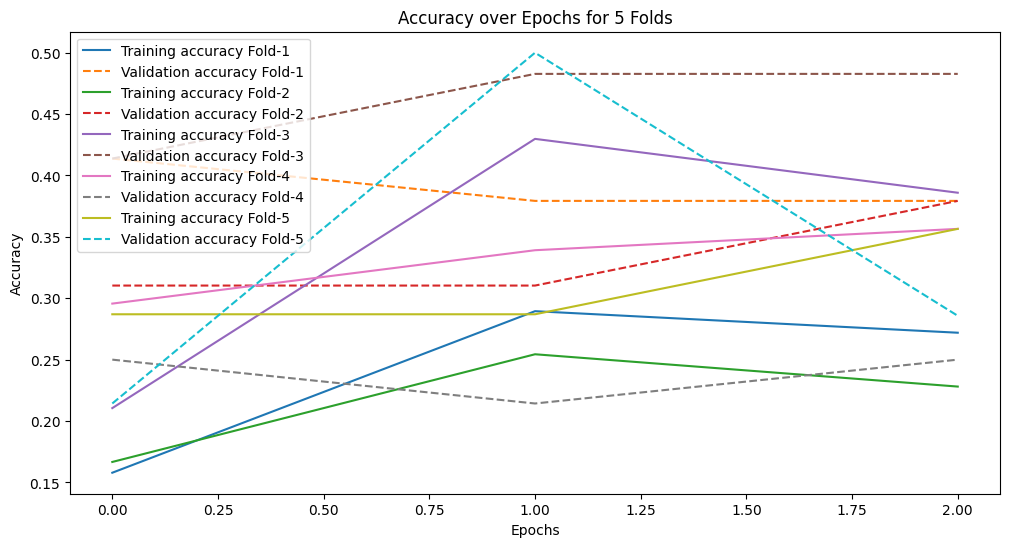

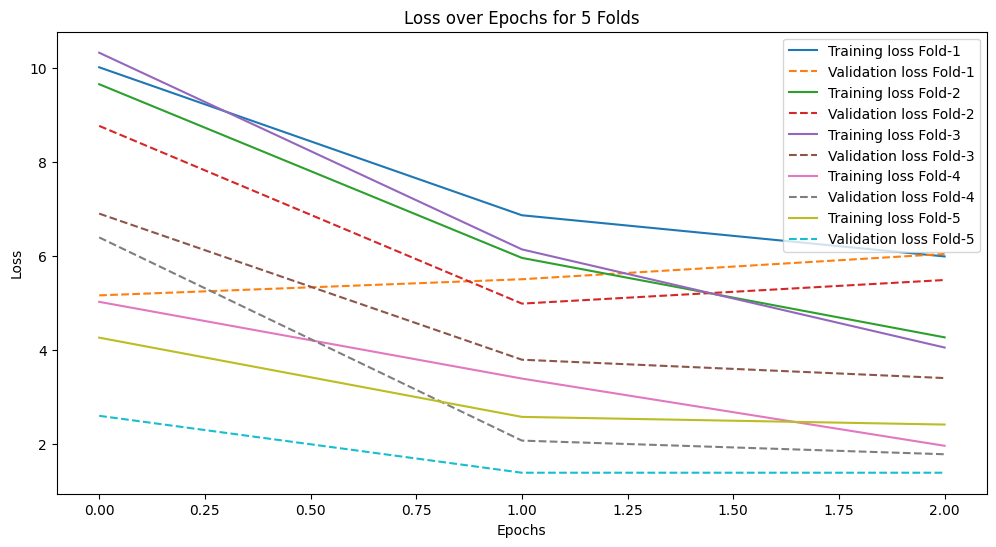

In [8]:
# plotting validation accuracy and loss accross epochs for each fold
def plot_metrics(history_per_fold, metric='accuracy'):
    # Number of folds
    n_folds = len(history_per_fold)
    
    # Create a new figure
    plt.figure(figsize=(12, 6))
    
    # Plot metrics for each fold
    for i, history in enumerate(history_per_fold, 1):
        plt.plot(history[metric], label=f'Training {metric} Fold-{i}')
        plt.plot(history[f'val_{metric}'], '--', label=f'Validation {metric} Fold-{i}')
    
    # Titles, labels, and legend
    plt.title(f'{metric.capitalize()} over Epochs for {n_folds} Folds')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

# Plot accuracy
plot_metrics(history_per_fold, metric='accuracy')

# Plot loss
plot_metrics(history_per_fold, metric='loss')


In [9]:
# Confusion matrix

predictions = model.predict(val_inputs)
y_pred = predictions.logits

y_pred_classes = np.argmax(y_pred, axis=1)

y_true_classes = val_labels

matrix = confusion_matrix(y_true_classes, y_pred_classes).numpy()

2023-08-16 18:32:27.808811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 62s 62s/step


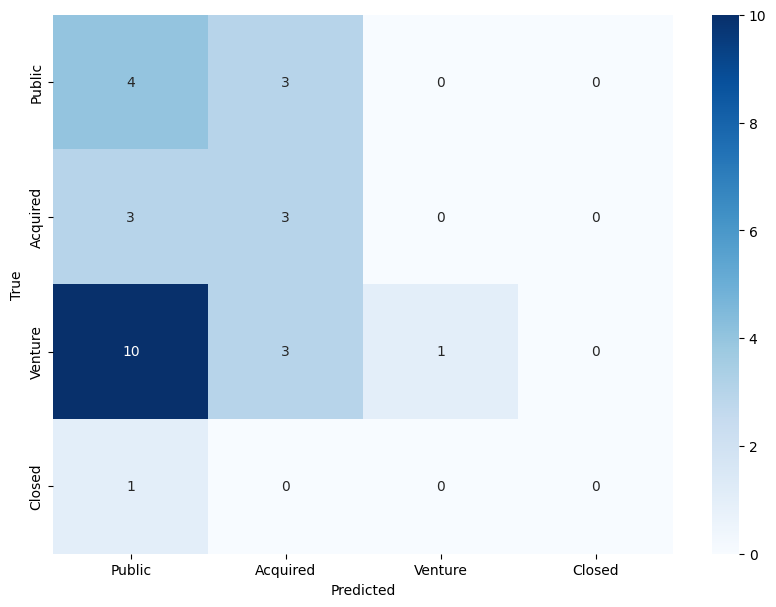

In [10]:
# Plot confusion matrix

class_names = ['Public', 'Acquired', 'Venture', 'Closed']

plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Confusion Matrix

A confusion matrix is a visualization tool used to assess classification model performance. Each row represents the actual classes, while each column signifies the predicted classes.

**Diagonal Elements**: Represent correct predictions (True Positives for each class).

**Off-Diagonal Elements**: Indicate misclassifications. The element in row x and column y shows the instances where the actual class x was predicted as class y.

A well-performing model will have higher values on the diagonal compared to off-diagonal elements, indicating accurate predictions.